# Prediction on age groups based on Asian face images

## load and clean data

In [88]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle
import face_recognitionk,
from PIL import Image
from sklearn.metrics import *

data_path = './facedata'

#[age]_[gender]_[race]_[date&time].jpg

def load_images_from_folder(folder):
    images = []
    age_group=[]
    count0 = 0
    count2 = 0
    count1 = 0
    female = {'0':0, '1':0, '2':0}
    male = {'0':0, '1':0, '2':0}
    for filename in folder:
        img = image = face_recognition.load_image_file(filename)
        face_locations = face_recognition.face_locations(img)
        try:
            a,b,c,d=face_locations[0]
            crop_img = img[a:c, d:b]
            
        except:
            continue
        filename = filename.split('_')
        temp = filename[0]
        temp = temp.split('/')
        try:
            age = int(temp[-1])
            gender_index = int(filename[1])
            #race_index = int(filename[2])
        except:
            continue
        if crop_img is not None:
            crop_img = cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)
            crop_img =cv2.resize(crop_img,(128,128))
            if age<=15 and count0 <= 3500:
                count0 += 1
                age_group += [0]
                images.append(crop_img)
                if gender_index == 0:
                    male['0'] += 1
                else:
                    female['0'] += 1
            elif age > 45 and count1 <= 3500:
                count1 += 1
                age_group+=[2]
                images.append(crop_img)
                if gender_index == 0:
                    male['2'] += 1
                else:
                    female['2'] += 1
            elif age > 15 and age <= 45 and count2 <= 3500:
                count2 += 1
                age_group += [1]
                images.append(crop_img)
                if gender_index == 0:
                    male['1'] += 1
                else:
                    female['1'] += 1
    return images,age_group,female,male

In [79]:
import os
import random
import sys
dir_name=sys.argv[1]
files = []
img_path = []
for filename in os.listdir(data_path):
    files.append(filename)
# shuffle list
random.shuffle(files)
for item in files:
    img_path.append(os.path.join(data_path,item))

In [80]:
face_data, ages, female_count, male_count=load_images_from_folder(img_path)

In [83]:
img_data = np.array(face_data)
ages = np.array(ages)
img_data = img_data.astype('float32')
img_data = img_data/255
img_data.shape

(10503, 128, 128)

In [81]:
len(face_data)

10503

### Sample image in dataset

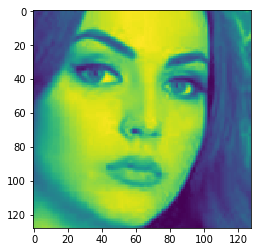

In [82]:
plt.imshow(face_data[710])

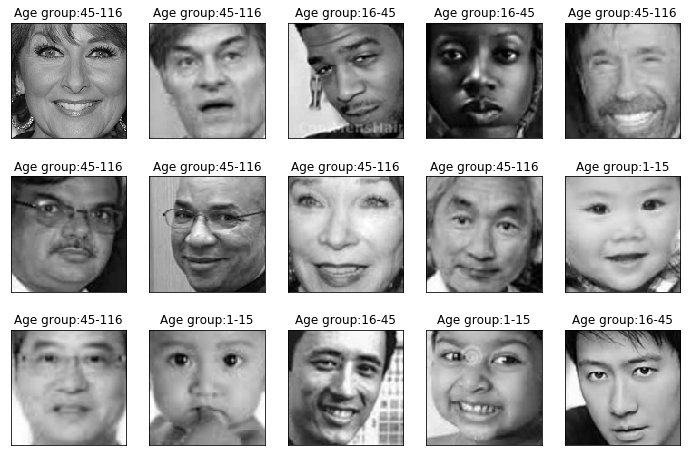

In [84]:
fs = (12, 8)
plt.figure(figsize=fs)
indices = np.random.randint(0, len(img_data)-1, 15)
sample_img = img_data[indices]
sample_age = ages[indices]
sample_group = []
for i in sample_age:
    if i==0:
        sample_group.append("1-15")
    elif i==1:
        sample_group.append("16-45")
    else:
        sample_group.append("45-116")
for i,im in enumerate(sample_img):
    plt.subplot(3, 5, i+1)
    plt.imshow(im, cmap='gray')
    plt.xticks(())
    plt.yticks(())
    plt.title('Age group:' + str(sample_group[i]))
plt.show()

# logistic regression

In [180]:
img_data2d=img_data.reshape([10503, 128*128])
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(img_data2d,ages, random_state=1)

In [181]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression(random_state=0)
logisticRegr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [182]:
y_predict_train = logisticRegr.predict(X_train)
print("Accuracy Score :{0:.2f}%".format(accuracy_score(y_train, y_predict_train)*100) )
print(classification_report(y_train, y_predict_train))
print(confusion_matrix(y_train, y_predict_train, labels=range(3)))

Accuracy Score :91.68%
             precision    recall  f1-score   support

          0       0.93      0.94      0.93      2659
          1       0.91      0.89      0.90      2595
          2       0.91      0.93      0.92      2623

avg / total       0.92      0.92      0.92      7877

[[2488  103   68]
 [ 137 2297  161]
 [  53  133 2437]]


In [183]:
y_predict = logisticRegr.predict(X_test)

# Evaluating metrics of my model
from sklearn.metrics import *

print("Accuracy Score :{0:.2f}%".format(accuracy_score(y_test, y_predict)*100) )
print(classification_report(y_test, y_predict))
print(confusion_matrix(y_test, y_predict, labels=range(3)))

Accuracy Score :54.80%
             precision    recall  f1-score   support

          0       0.60      0.62      0.61       842
          1       0.50      0.51      0.50       906
          2       0.55      0.52      0.54       878

avg / total       0.55      0.55      0.55      2626

[[518 192 132]
 [205 461 240]
 [142 276 460]]


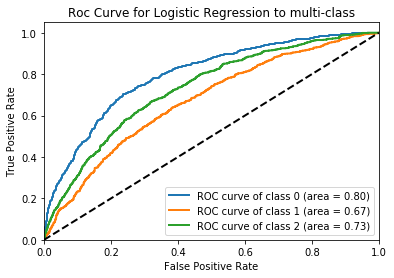

In [184]:
import numpy as np

y_predict_proba = logisticRegr.predict_proba(X_test)

# Compute ROC curve and ROC AUC for each class
n_classes = 3
fpr = dict()
tpr = dict()
roc_auc = dict()
all_y_test_i = np.array([])
all_y_predict_proba = np.array([])
for i in range(n_classes):
    y_test_i = map(lambda x: 1 if x == i else 0, y_test)
    y_test_i=np.fromiter(y_test_i, dtype=np.int)
    all_y_test_i = np.append(all_y_test_i, [y_test_i])
    all_y_predict_proba = np.append(all_y_predict_proba, [y_predict_proba[:, i]])
    fpr[i], tpr[i], _ = roc_curve(y_test_i, y_predict_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["average"], tpr["average"], _ = roc_curve(all_y_test_i, all_y_predict_proba)
roc_auc["average"] = auc(fpr["average"], tpr["average"])


# Plot average ROC Curve
# plt.figure()
# plt.plot(fpr["average"], tpr["average"],
#          label='Average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["average"]),
#          color='deeppink', linestyle=':', linewidth=4)

# Plot each individual ROC curve
plt.figure()

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc Curve for Logistic Regression to multi-class')
plt.legend(loc="lower right")
plt.show()

## SVM

1. Reshape data into a vector
2. Use PCA to calculate eigenfaces
3. Train SVM with best hyper-parameter C and gamma
4. Perforamance Analysis

In [259]:
img_data2d=img_data.reshape([10503, 128*128])
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(img_data2d,ages, random_state=1)

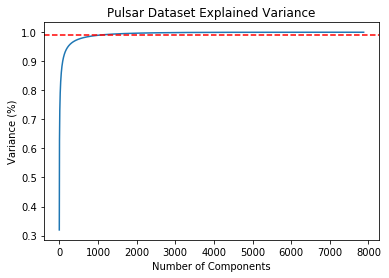

In [100]:
from sklearn.decomposition import PCA
#Fitting the PCA algorithm with our Data
pca = PCA(whiten=True, svd_solver='randomized').fit(X_train)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.axhline(y = 0.99, color='r', linestyle='--')
plt.show()

In [101]:
cumpca=np.cumsum(pca.explained_variance_ratio_)
for i in range(len(cumpca)):
    if cumpca[i]>=0.99:
        n_comp=i
        print(i)
        break

1031


In [204]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=1031, whiten=True, svd_solver='randomized')
pca.fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print(X_train_pca.shape)
print(X_test_pca.shape)

(7877, 1031)
(2626, 1031)


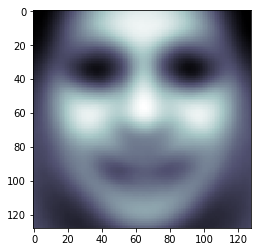

In [212]:
plt.imshow(pca.mean_.reshape((128, 128)), cmap=plt.cm.bone)

In [111]:
from sklearn.grid_search import GridSearchCV
param_grid = {
    'C': [1e3, 5e3, 1e4, 5e4, 1e5],
    'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
}
clf2 = GridSearchCV(svm.SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf2 = clf2.fit(X_train_pca, y_train)
print("Best estimator found by randomized hyper parameter search:")
print(clf2.best_params_)
print("Best parameters validation score: {:.3f}".format(clf2.best_score_))

Best estimator found by randomized hyper parameter search:
{'C': 1000.0, 'gamma': 0.001}
Best parameters validation score: 0.561


In [114]:
y_pred2 = clf2.predict(X_test_pca)
print("Accuracy Score :{0:.2f}%".format(accuracy_score(y_test, y_pred2)*100) )
print(classification_report(y_test, y_pred2))
print(confusion_matrix(y_test, y_pred2, labels=range(3)))

Accuracy Score :59.29%
             precision    recall  f1-score   support

          0       0.64      0.68      0.66       842
          1       0.54      0.52      0.53       906
          2       0.59      0.58      0.59       878

avg / total       0.59      0.59      0.59      2626

[[573 149 120]
 [197 471 238]
 [120 245 513]]


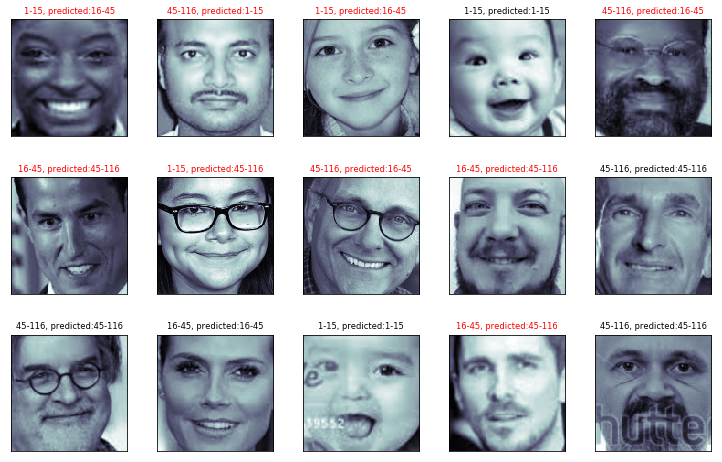

In [134]:
import pylab as pl
fig = plt.figure(figsize=(10, 5))
pl.subplots_adjust(bottom=0, left=.01, right=.99, top=1.20, hspace=.35)
sample_group = []
pred_group=[]
for i in y_test[:15]:
    if i==0:
        sample_group.append("1-15")
    elif i==1:
        sample_group.append("16-45")
    else:
        sample_group.append("45-116")
for i in y_pred2[:15]:
    if i==0:
        pred_group.append("1-15")
    elif i==1:
        pred_group.append("16-45")
    else:
        pred_group.append("45-116")
for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(X_test[i].reshape((128, 128)), cmap=plt.cm.bone)
    color = 'black' if pred_group[i] == sample_group[i] else 'red'
    title = '%s, predicted:%s' % (sample_group[i],pred_group[i])
    ax.set_title(title, fontsize='small', color=color)

In [262]:
from sklearn import svm
clf_svm = svm.SVC(kernel='rbf', C=1000, gamma=0.001, class_weight = 'balanced', probability=True)
clf_svm.fit(X_train_pca, y_train)
# plt.imshow(pca.mean_.reshape((128, 128)), cmap=plt.cm.bone)
# eigenfaces = pca.components_.reshape((1031, 128, 128))
# # eigenfaces.shape
# y_pred2 = clf.predict(X_test_pca)
# print("Accuracy Score :{0:.2f}%".format(accuracy_score(y_test, y_pred2)*100) )
# print(classification_report(y_test, y_pred2))
# print(confusion_matrix(y_test, y_pred2, labels=range(3)))


SVC(C=1000, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

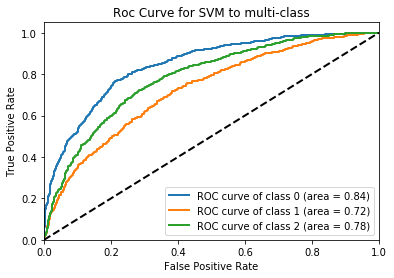

In [265]:
import numpy as np

y_predict_proba = clf_svm.predict_proba(X_test_pca)

# Compute ROC curve and ROC AUC for each class
n_classes = 3
fpr = dict()
tpr = dict()
roc_auc = dict()
all_y_test_i = np.array([])
all_y_predict_proba = np.array([])
for i in range(n_classes):
    y_test_i = map(lambda x: 1 if x == i else 0, y_test)
    y_test_i=np.fromiter(y_test_i, dtype=np.int)
    all_y_test_i = np.append(all_y_test_i, [y_test_i])
    all_y_predict_proba = np.append(all_y_predict_proba, [y_predict_proba[:, i]])
    fpr[i], tpr[i], _ = roc_curve(y_test_i, y_predict_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["average"], tpr["average"], _ = roc_curve(all_y_test_i, all_y_predict_proba)
roc_auc["average"] = auc(fpr["average"], tpr["average"])


# Plot average ROC Curve
# plt.figure()
# plt.plot(fpr["average"], tpr["average"],
#          label='Average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["average"]),
#          color='deeppink', linestyle=':', linewidth=4)

# Plot each individual ROC curve
plt.figure()

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc Curve for SVM to multi-class')
plt.legend(loc="lower right")
plt.show()

# random forest

In [175]:
X_train_pca.shape

(7877, 1031)

In [232]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

y_train = label_binarize(y_train, classes=[0, 1, 2])
y_test = label_binarize(y_test, classes=[0, 1, 2])
print("Find best n_estimators")
for i in range(1,8):
    print("for n_estimators =",i)
    clf = OneVsRestClassifier(RandomForestClassifier(n_estimators= i, random_state = 0))
    clf.fit(X_train_pca, y_train)
    y_predict = clf.predict(X_test_pca)
    print("Test accuracy Score :{0:.2f}%".format(accuracy_score(y_test, y_predict)*100))
    y_predict_train = clf.predict(X_train_pca)
    # Evaluating metrics of my model
    print("Train accuracy Score :{0:.2f}%".format(accuracy_score(y_train, y_predict_train)*100))


Find best n_estimators
for n_estimators = 1
Test accuracy Score :19.54%
Train accuracy Score :70.83%
for n_estimators = 2
Test accuracy Score :14.78%
Train accuracy Score :61.51%
for n_estimators = 3
Test accuracy Score :20.14%
Train accuracy Score :83.28%
for n_estimators = 4
Test accuracy Score :13.98%
Train accuracy Score :78.56%
for n_estimators = 5
Test accuracy Score :20.49%
Train accuracy Score :90.31%
for n_estimators = 6
Test accuracy Score :15.80%
Train accuracy Score :87.25%
for n_estimators = 7
Test accuracy Score :20.37%
Train accuracy Score :93.97%


In [235]:
print("Find best max_depth")
for i in range(10,80,10):
    print("for n_estimators =",i)
    clf = OneVsRestClassifier(RandomForestClassifier(n_estimators= 5, max_depth=i, random_state = 0))
    clf.fit(X_train_pca, y_train)
    y_predict = clf.predict(X_test_pca)
    print("Test accuracy Score :{0:.2f}%".format(accuracy_score(y_test, y_predict)*100))
    y_predict_train = clf.predict(X_train_pca)
    # Evaluating metrics of my model
    print("Train accuracy Score :{0:.2f}%".format(accuracy_score(y_train, y_predict_train)*100))

Find best max_depth
for n_estimators = 10
Test accuracy Score :14.70%
Train accuracy Score :41.93%
for n_estimators = 20
Test accuracy Score :19.50%
Train accuracy Score :84.82%
for n_estimators = 30
Test accuracy Score :19.95%
Train accuracy Score :89.58%
for n_estimators = 40
Test accuracy Score :20.18%
Train accuracy Score :90.35%
for n_estimators = 50
Test accuracy Score :20.49%
Train accuracy Score :90.31%
for n_estimators = 60
Test accuracy Score :20.49%
Train accuracy Score :90.31%
for n_estimators = 70
Test accuracy Score :20.49%
Train accuracy Score :90.31%


In [240]:
clf = OneVsRestClassifier(RandomForestClassifier(n_estimators= 5, max_depth=50, random_state = 0))
clf.fit(X_train_pca, y_train)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
          n_jobs=1)

In [241]:
y_predict = clf.predict(X_test_pca)
# Evaluating metrics of my model
from sklearn.metrics import *
print("Accuracy Score :{0:.2f}%".format(accuracy_score(y_test, y_predict)*100))
print(classification_report(y_test, y_predict))

Accuracy Score :20.49%
             precision    recall  f1-score   support

          0       0.44      0.35      0.39       842
          1       0.41      0.29      0.34       906
          2       0.42      0.31      0.35       878

avg / total       0.42      0.31      0.36      2626



In [242]:
y_predict = clf.predict(X_train_pca)
# Evaluating metrics of my model
print("Accuracy Score :{0:.2f}%".format(accuracy_score(y_train, y_predict)*100))
print(classification_report(y_train, y_predict))

Accuracy Score :90.31%
             precision    recall  f1-score   support

          0       0.97      0.92      0.94      2659
          1       0.96      0.92      0.94      2595
          2       0.96      0.92      0.94      2623

avg / total       0.96      0.92      0.94      7877



In [244]:
y_score = clf.fit(X_train, y_train).predict_proba(X_test)
fpr = {}
tpr = {}
roc_auc = {}
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [263]:
from itertools import cycle

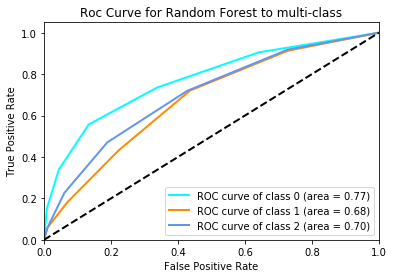

In [264]:
# First aggregate all false positive rates
n_classes = 3
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(3)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

# Plot all ROC curves
plt.figure()

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc Curve for Random Forest to multi-class')
plt.legend(loc="lower right")